This project tackles a Kaggle Competition by AirBnB to predict which country a new user will make their first booking. The training dataset consists of features such as user activity, date of first booking, date of account creation etc. Other datasets such as each session were also provided. Model performance metric is evaluated using [Normalized discounted cumulative gain (NDCG)](https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/overview/evaluation).


Things to focus on:
    - feature engineering (aggregations, kurtosis, skewness, entropy)
    - explainability (permutation importance, partial plots, SHAP)
    - model performance - gridsearch, pipelines    


### Exploratory Data Analysis

In [23]:
import pandas as pd
import numpy as np
import category_encoders as ce
from datetime import datetime
import time
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, plot_confusion_matrix, f1_score, ndcg_score
from xgboost import XGBClassifier, plot_importance, plot_tree
import graphviz
from pdpbox import pdp, get_dataset, info_plots
import shap
import eli5
from eli5.sklearn import PermutationImportance

In [2]:
train = pd.read_csv('train_users_2.csv')
train

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213446,zxodksqpep,2014-06-30,20140630235636,NaN,MALE,32.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,NDF
213447,mhewnxesx9,2014-06-30,20140630235719,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF
213448,6o3arsjbb4,2014-06-30,20140630235754,NaN,-unknown-,32.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF
213449,jh95kwisub,2014-06-30,20140630235822,NaN,-unknown-,NaN,basic,25,en,other,other,tracked-other,iOS,iPhone,Mobile Safari,NDF


In [3]:
train.describe()

,timestamp_first_active,age,signup_flow
count,2.134510e+05,125461.000000,213451.000000
mean,2.013085e+13,49.668335,3.267387
std,9.253717e+09,155.666612,7.637707
min,2.009032e+13,1.000000,0.000000
25%,2.012123e+13,28.000000,0.000000
50%,2.013091e+13,34.000000,0.000000
75%,2.014031e+13,43.000000,0.000000
max,2.014063e+13,2014.000000,25.000000


NDF = no destination found, meaning the user did not make a booking


In [4]:
train.country_destination.value_counts()

NDF      124543
US        62376
other     10094
FR         5023
IT         2835
GB         2324
ES         2249
CA         1428
DE         1061
NL          762
AU          539
PT          217
Name: country_destination, dtype: int64

We see that about 1/2 of `date_first_booking`, 1/3 of `age` and a small % of `first_affiliate_tracked` are null values. That means 1/2 of the people never made their first booking and so we should rightfully replace the date by 0. For age we can replace with the mean/median age. For first affiliate tracked we shall do a categorical encoding for the null values. 

In [5]:
train.isnull().sum(axis=0) # we see that there are some NaNs

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

Data Preprocessing

    - Missing
        - date_first_booking --> replace with 0
        - age --> fill with mean age
        - first_affiliate_tracked --> encode as a class
    - Categorical
        - gender, signup_method, signup_flow, language, country
        - affiliate_channel, affiliate_provider, first_browser
        - first_affiliate_tracked, signup_app, first_device_type
    - Time --> split into individual 
        - date_account_created
        - date_first_booking
        - timestamp_first_active

In [6]:
# deal with missing values and datetimes
train2 = train
train2.date_first_booking.fillna(pd.Timestamp(1990, 1, 1), inplace=True)
train2.age.fillna(np.mean(train2.age), inplace=True)
train2.age[train2.age > 200] = np.mean(train2.age) # there were some faulty data points where age > 200
train2

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,1990-01-01 00:00:00,-unknown-,49.668335,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,1990-01-01 00:00:00,MALE,38.000000,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.000000,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.000000,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.000000,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213446,zxodksqpep,2014-06-30,20140630235636,1990-01-01 00:00:00,MALE,32.000000,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,NDF
213447,mhewnxesx9,2014-06-30,20140630235719,1990-01-01 00:00:00,-unknown-,49.668335,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF
213448,6o3arsjbb4,2014-06-30,20140630235754,1990-01-01 00:00:00,-unknown-,32.000000,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF
213449,jh95kwisub,2014-06-30,20140630235822,1990-01-01 00:00:00,-unknown-,49.668335,basic,25,en,other,other,tracked-other,iOS,iPhone,Mobile Safari,NDF


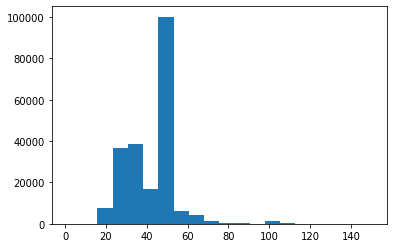

In [7]:
plt.hist(train2.age, bins=20)
plt.show()

In [8]:
# convert string timestamps to datetime

train2.timestamp_first_active = pd.to_datetime(train2.timestamp_first_active, format='%Y%m%d%H%M%S').dt.round('1d')
train2.date_first_booking = pd.to_datetime(train2.date_first_booking).dt.round('1d')
train2.date_account_created = pd.to_datetime(train2.date_account_created)
train2

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2009-03-19,1990-01-01,-unknown-,49.668335,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,2009-05-24,1990-01-01,MALE,38.000000,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-10,2010-08-02,FEMALE,56.000000,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31,2012-09-08,FEMALE,42.000000,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08,2010-02-18,-unknown-,41.000000,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213446,zxodksqpep,2014-06-30,2014-07-01,1990-01-01,MALE,32.000000,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,NDF
213447,mhewnxesx9,2014-06-30,2014-07-01,1990-01-01,-unknown-,49.668335,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF
213448,6o3arsjbb4,2014-06-30,2014-07-01,1990-01-01,-unknown-,32.000000,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF
213449,jh95kwisub,2014-06-30,2014-07-01,1990-01-01,-unknown-,49.668335,basic,25,en,other,other,tracked-other,iOS,iPhone,Mobile Safari,NDF


Let's try to visualize the time series of countries booked for each month using a rolling stacked bar chart. We can generally see that the number of bookings increased over time and peaked mid 2014, after which it dropped significantly and continued decreasing over time. We also see that majority of bookings are for the US, followed by AU and FR.

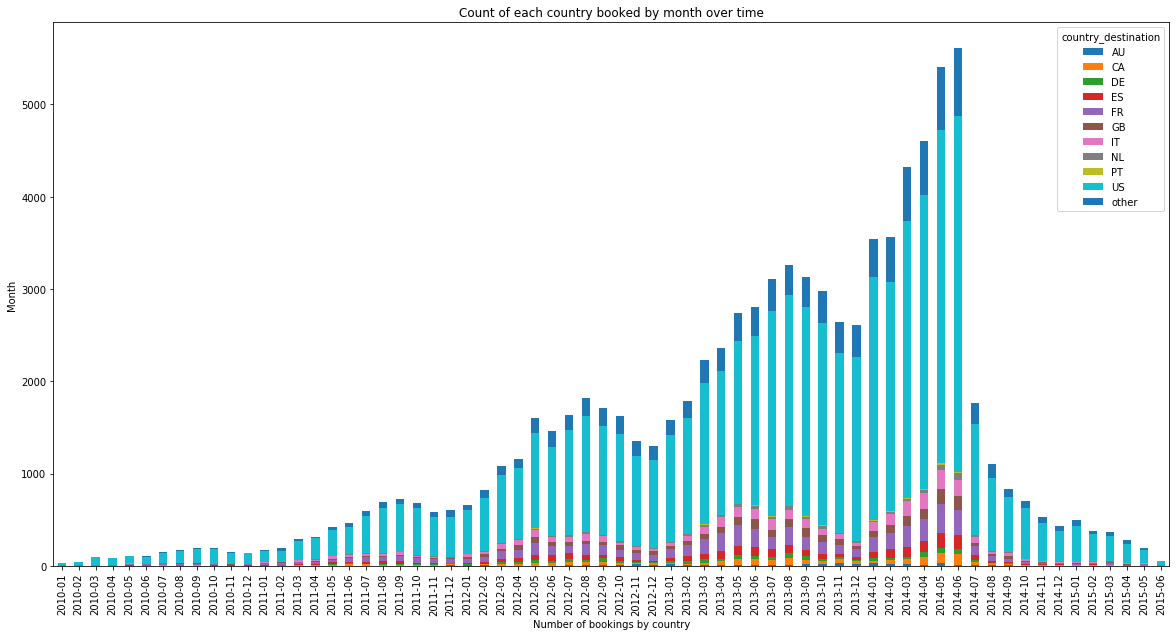

In [9]:
# plot count of each country booked by month over time
viz = train2[train2.date_first_booking > train2.date_first_booking.min()] # only show those who booked
viz['month_year'] = train2.date_first_booking.dt.to_period('M')
viz = viz.groupby(['month_year', 'country_destination']).count()
title = 'Count of each country booked by month over time'
viz.id.unstack().plot(kind='bar', stacked=True, figsize=(20,10), title=title)
plt.xlabel('Number of bookings by country')
plt.ylabel('Month')
plt.show()

In [10]:
# Count Categorical Encoding

cat_features = ['gender', 'signup_method', 'signup_flow', 'language', 
                'affiliate_channel', 'affiliate_provider', 'first_browser',
                'first_affiliate_tracked', 'signup_app', 'first_device_type', 
                'country_destination']
train2[cat_features] = ce.CountEncoder().fit_transform(train2[cat_features])
train2.rename(columns={'id': 'user_id'}, inplace=True)
train2

,user_id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2009-03-19,1990-01-01,95688,49.668335,60008,0,206314,137727,137426,109232,182717,89600,63845,124543
1,820tgsjxq7,2011-05-25,2009-05-24,1990-01-01,54440,38.000000,60008,0,206314,8663,51693,109232,182717,89600,63845,124543
2,4ft3gnwmtx,2010-09-28,2009-06-10,2010-08-02,63041,56.000000,152897,3,206314,137727,137426,109232,182717,72716,21068,62376
3,bjjt8pjhuk,2011-12-05,2009-10-31,2012-09-08,63041,42.000000,60008,0,206314,137727,137426,109232,182717,89600,33655,10094
4,87mebub9p4,2010-09-14,2009-12-08,2010-02-18,95688,41.000000,152897,0,206314,137727,137426,109232,182717,89600,63845,62376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213446,zxodksqpep,2014-06-30,2014-07-01,1990-01-01,54440,32.000000,152897,0,206314,26045,51693,43982,182717,89600,45169,124543
213447,mhewnxesx9,2014-06-30,2014-07-01,1990-01-01,95688,49.668335,152897,0,206314,137727,137426,46287,182717,72716,63845,124543
213448,6o3arsjbb4,2014-06-30,2014-07-01,1990-01-01,95688,32.000000,152897,0,206314,137727,137426,109232,182717,89600,33655,124543
213449,jh95kwisub,2014-06-30,2014-07-01,1990-01-01,95688,49.668335,152897,25,206314,8961,12549,6156,19019,20759,19274,124543


Next let us explore the sessions dataset, which consists of 10 million rows of user activity. Unfortuntely there is no datetime on each of the users actions but there are details. 

**Categorical values**

    - action
    - action_type
    - action_detail
    - device_type
    
**Missing Values**

    - user_id --> remove rows as cannot join
    - action --> categorically encode as "no action"
    - action_type --> categorically encode as "no action"
    - action_detail --> categorically encode as "no action"
    - secs_elapsed --> fill it with the mean of action 

In [11]:
train2.isnull().sum(axis=0) # check that we have no more NaNs 

user_id                    0
date_account_created       0
timestamp_first_active     0
date_first_booking         0
gender                     0
age                        0
signup_method              0
signup_flow                0
language                   0
affiliate_channel          0
affiliate_provider         0
first_affiliate_tracked    0
signup_app                 0
first_device_type          0
first_browser              0
country_destination        0
dtype: int64

In [12]:
sessions = pd.read_csv('sessions.csv')
sessions

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0
...,...,...,...,...,...,...
10567732,9uqfg8txu3,dashboard,view,dashboard,Windows Desktop,556.0
10567733,9uqfg8txu3,edit,view,edit_profile,Windows Desktop,6624.0
10567734,9uqfg8txu3,webcam_upload,-unknown-,-unknown-,Windows Desktop,200125.0
10567735,9uqfg8txu3,active,-unknown-,-unknown-,-unknown-,17624.0


In [13]:
sessions.isnull().sum(axis=0) # check NaNs

user_id            34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64

We see that there are some missing values. Lets see what data processing we need to do:
    - Missing Values
        - user_id --> remove them since we cant join
        - action / action_detail --> categorically encode NaNs as no action
        - secs_elapsed --> fill with 0, but not sure if this will significantly affect our 
    - Categorical Values (Count Encoding)
        - action
        - action_type
        - action_detail
        - device_type
        
Our final result has ~10.5 million rows, about 30K rows lesser.

In [14]:
sessions2 = sessions[pd.notnull(sessions.user_id)]
sessions2.secs_elapsed.fillna(0, inplace=True)
cat_features = ['action', 'action_type', 'action_detail', 'device_type']
sessions2[cat_features] = ce.CountEncoder().fit_transform(sessions2[cat_features])
sessions2

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,161422,1122957,1122957,2648521,319.0
1,d1mm9tcy42,723124,1990058,1771026,2648521,67753.0
2,d1mm9tcy42,161422,1122957,1122957,2648521,301.0
3,d1mm9tcy42,723124,1990058,1771026,2648521,22141.0
4,d1mm9tcy42,161422,1122957,1122957,2648521,435.0
...,...,...,...,...,...,...
10567732,9uqfg8txu3,152515,3549375,152515,2648521,556.0
10567733,9uqfg8txu3,108927,3549375,108531,2648521,6624.0
10567734,9uqfg8txu3,815,1028251,1028222,2648521,200125.0
10567735,9uqfg8txu3,187370,1028251,1028222,210059,17624.0


In [15]:
sessions2.isnull().sum(axis=0) # check no more NaNs

user_id          0
action           0
action_type      0
action_detail    0
device_type      0
secs_elapsed     0
dtype: int64

In [16]:
sessions2.groupby('user_id').count() # there are only 135,000 users who have taken action the rest have not 

,action,action_type,action_detail,device_type,secs_elapsed
user_id,,,,,
00023iyk9l,40,40,40,40,40
0010k6l0om,63,63,63,63,63
001wyh0pz8,90,90,90,90,90
0028jgx1x1,31,31,31,31,31
002qnbzfs5,789,789,789,789,789
...,...,...,...,...,...
zzxox7jnrx,89,89,89,89,89
zzy7t0y9cm,8,8,8,8,8
zzysuoqg6x,3,3,3,3,3


### Feature Engineering


**Users:**
- extract day/month/year from the dates. 
- number of Actions between first_active and date_booking

**Sessions:**

- Number of actions taken (DONE)
- Count/mean/min/max/median of unique Actions, ActionTypes, ActionDetails, Devices (DONE)
- Sum/mean/min/max/median/s.d./skewness/kurtosis of seconds_elapsed (DONE)
- Entropy of Actions, ActionTypes, ActionDetails, Devices, Secs_elapsed of the first, second, last, second-to-last, and third-to-last Actions
- Ratios of unique Actions, ActionTypes, ActionDetails, Devices
- Ratios of entropies

In [17]:
def aggregate_features(data, key, cols, name=''):
    agg = data.groupby(cols).count().groupby(key)[data.columns[-1]]
    df = pd.DataFrame()
    df['min_' + name] = agg.min()
    df['max_' + name] = agg.max()
    df['mean_' + name] = agg.mean()
    df['median_' + name] = agg.median()
    df['std_' + name] = agg.std()
    return df

def generate_features(df, df_agg, cols, names, key):
    df = df.merge(pd.DataFrame(data={'total_counts': df_agg.groupby(key).count().iloc[:, 0]}), how='left', on=key)
    for col, name in zip(cols, names):
        df = df.merge(aggregate_features(df_agg, key, col, name), how='left', on=key)
    return df

In [18]:
# compute mean, median, min, max number of bids per user per auction / merchandise / device / URL
key = 'user_id'
names = ['action', 'action_type', 'action_detail', 'device_type']
cols = [[key, name] for name in names]
train3 = generate_features(train2, sessions2, cols, names, key=key).fillna(0)
train3

,user_id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,min_action_detail,max_action_detail,mean_action_detail,median_action_detail,std_action_detail,min_device_type,max_device_type,mean_device_type,median_device_type,std_device_type
0,gxn3p5htnn,2010-06-28,2009-03-19,1990-01-01,95688,49.668335,60008,0,206314,137727,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
1,820tgsjxq7,2011-05-25,2009-05-24,1990-01-01,54440,38.000000,60008,0,206314,8663,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
2,4ft3gnwmtx,2010-09-28,2009-06-10,2010-08-02,63041,56.000000,152897,3,206314,137727,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
3,bjjt8pjhuk,2011-12-05,2009-10-31,2012-09-08,63041,42.000000,60008,0,206314,137727,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
4,87mebub9p4,2010-09-14,2009-12-08,2010-02-18,95688,41.000000,152897,0,206314,137727,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213446,zxodksqpep,2014-06-30,2014-07-01,1990-01-01,54440,32.000000,152897,0,206314,26045,...,1.0,26.0,4.583333,2.0,6.071435,2.0,108.0,55.000000,55.0,74.953319
213447,mhewnxesx9,2014-06-30,2014-07-01,1990-01-01,95688,49.668335,152897,0,206314,137727,...,1.0,64.0,10.818182,2.0,17.470073,2.0,232.0,79.333333,4.0,132.216993
213448,6o3arsjbb4,2014-06-30,2014-07-01,1990-01-01,95688,32.000000,152897,0,206314,137727,...,1.0,3.0,1.636364,2.0,0.674200,18.0,18.0,18.000000,18.0,0.000000
213449,jh95kwisub,2014-06-30,2014-07-01,1990-01-01,95688,49.668335,152897,25,206314,8961,...,1.0,39.0,8.333333,5.0,12.000000,75.0,75.0,75.000000,75.0,0.000000


Let us now compute features for secs_elaposed for each action, where we can compute the standard stuff like mean, median, max and standard deviation. min turned out to be all zeros so we can skip it. We can also compute the skewness and kurtosis. 

   - **Skewness** is a measure of symmetry, or more precisely, the lack of symmetry. A distribution, or data set, is   symmetric if it looks the same to the left and right of the center point.

   - **Kurtosis** is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. That is, data sets with high kurtosis tend to have heavy tails, or outliers. Data sets with low kurtosis tend to have light tails, or lack of outliers. A uniform distribution would be the extreme case.

In [19]:
# compute Sum/mean/min/max/median/s.d./skewness/kurtosis of seconds_elapsed

name = 'secs'
agg = sessions2.groupby(['user_id']).secs_elapsed
df = pd.DataFrame()
# df['min_' + name] = agg.min() --> all 0s so unuseful
df['max_' + name] = agg.max()
df['mean_' + name] = agg.mean()
df['median_' + name] = agg.median()
df['std_' + name] = agg.std()
df['kurt_' + name] = agg.apply(pd.DataFrame.kurt)
train4 = train3.merge(df, on='user_id', how='left').fillna(0)
train4

,user_id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,min_device_type,max_device_type,mean_device_type,median_device_type,std_device_type,max_secs,mean_secs,median_secs,std_secs,kurt_secs
0,gxn3p5htnn,2010-06-28,2009-03-19,1990-01-01,95688,49.668335,60008,0,206314,137727,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
1,820tgsjxq7,2011-05-25,2009-05-24,1990-01-01,54440,38.000000,60008,0,206314,8663,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
2,4ft3gnwmtx,2010-09-28,2009-06-10,2010-08-02,63041,56.000000,152897,3,206314,137727,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
3,bjjt8pjhuk,2011-12-05,2009-10-31,2012-09-08,63041,42.000000,60008,0,206314,137727,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
4,87mebub9p4,2010-09-14,2009-12-08,2010-02-18,95688,41.000000,152897,0,206314,137727,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213446,zxodksqpep,2014-06-30,2014-07-01,1990-01-01,54440,32.000000,152897,0,206314,26045,...,2.0,108.0,55.000000,55.0,74.953319,1445590.0,46739.963636,1686.5,166237.234458,47.650318
213447,mhewnxesx9,2014-06-30,2014-07-01,1990-01-01,95688,49.668335,152897,0,206314,137727,...,2.0,232.0,79.333333,4.0,132.216993,748658.0,12096.319328,563.0,60030.505588,106.847946
213448,6o3arsjbb4,2014-06-30,2014-07-01,1990-01-01,95688,32.000000,152897,0,206314,137727,...,18.0,18.0,18.000000,18.0,0.000000,149128.0,19054.555556,1278.5,42591.771128,5.133301
213449,jh95kwisub,2014-06-30,2014-07-01,1990-01-01,95688,49.668335,152897,25,206314,8961,...,75.0,75.0,75.000000,75.0,0.000000,66636.0,4554.786667,2272.0,8925.899713,34.005164


Let us finish processing the date variables 
 - compute the average number of actions between first active and first booking
 - convert all date variables into day / month / year

In [20]:
#train5['actions_over_time'] = train5.total_counts / (train5.date_first_booking - train5.timestamp_first_active).dt.total_seconds()*86400
for col in ['date_account_created', 'timestamp_first_active']:
    train4[col + '_day'] = train4[col].dt.day
    train4[col + '_month'] = train4[col].dt.month
    train4[col + '_year'] = train4[col].dt.year
train4

,user_id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,mean_secs,median_secs,std_secs,kurt_secs,date_account_created_day,date_account_created_month,date_account_created_year,timestamp_first_active_day,timestamp_first_active_month,timestamp_first_active_year
0,gxn3p5htnn,2010-06-28,2009-03-19,1990-01-01,95688,49.668335,60008,0,206314,137727,...,0.000000,0.0,0.000000,0.000000,28,6,2010,19,3,2009
1,820tgsjxq7,2011-05-25,2009-05-24,1990-01-01,54440,38.000000,60008,0,206314,8663,...,0.000000,0.0,0.000000,0.000000,25,5,2011,24,5,2009
2,4ft3gnwmtx,2010-09-28,2009-06-10,2010-08-02,63041,56.000000,152897,3,206314,137727,...,0.000000,0.0,0.000000,0.000000,28,9,2010,10,6,2009
3,bjjt8pjhuk,2011-12-05,2009-10-31,2012-09-08,63041,42.000000,60008,0,206314,137727,...,0.000000,0.0,0.000000,0.000000,5,12,2011,31,10,2009
4,87mebub9p4,2010-09-14,2009-12-08,2010-02-18,95688,41.000000,152897,0,206314,137727,...,0.000000,0.0,0.000000,0.000000,14,9,2010,8,12,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213446,zxodksqpep,2014-06-30,2014-07-01,1990-01-01,54440,32.000000,152897,0,206314,26045,...,46739.963636,1686.5,166237.234458,47.650318,30,6,2014,1,7,2014
213447,mhewnxesx9,2014-06-30,2014-07-01,1990-01-01,95688,49.668335,152897,0,206314,137727,...,12096.319328,563.0,60030.505588,106.847946,30,6,2014,1,7,2014
213448,6o3arsjbb4,2014-06-30,2014-07-01,1990-01-01,95688,32.000000,152897,0,206314,137727,...,19054.555556,1278.5,42591.771128,5.133301,30,6,2014,1,7,2014
213449,jh95kwisub,2014-06-30,2014-07-01,1990-01-01,95688,49.668335,152897,25,206314,8961,...,4554.786667,2272.0,8925.899713,34.005164,30,6,2014,1,7,2014


### Model Building

Lets being building the model by first dropping the non-numeric columns and target, before fitting it onto XGBoost classifier. Now note that although the F-Score is rather low, the competition metric is [Normalized Discounted Cumulative Gain (NDCG)](https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/overview/evaluation) so we shall use that instead, and we can see that a baseline model attains a pretty good score of 0.82

In [21]:
from imblearn.under_sampling import RandomUnderSampler

y = train4.country_destination
X = train4.drop(['country_destination', 'user_id', 'date_first_booking', 'date_account_created', 'timestamp_first_active'], axis=1)

Using TensorFlow backend.


In [24]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# define custom class to fix bug in xgboost 1.0.2
class MyXGBClassifier(XGBClassifier):
    @property
    def coef_(self):
        return None
    
xgb = MyXGBClassifier()
xgb.fit(X_train, y_train)
print("F-Score: {}".format(xgb.score(X_val, y_val)))

y_pred = xgb.predict_proba(X_val)
y_true = LabelBinarizer().fit_transform(y_val)
print("NDCG Score: {}".format(ndcg_score(y_true, y_pred, k=5)))


F-Score: 0.6473027101731044
NDCG Score: 0.8295152892487626


## Model Explainability

- 1.Feature Importance
- 2.Decision Tree Structure
- 3.Partial Dependence Plots
- 4.SHAP Values

### Feature Importance 

Permutation importance is calculated after a model has been fitted. So we won't change the model or change what predictions we'd get for a given value of height, sock-count, etc.

Instead we will ask the following question: If I randomly shuffle a single column of the validation data, leaving the target and all other columns in place, how would that affect the accuracy of predictions in that now-shuffled data?

Here we can see that our top 3 features are age, median time spent for each action and the day that the account was created. 

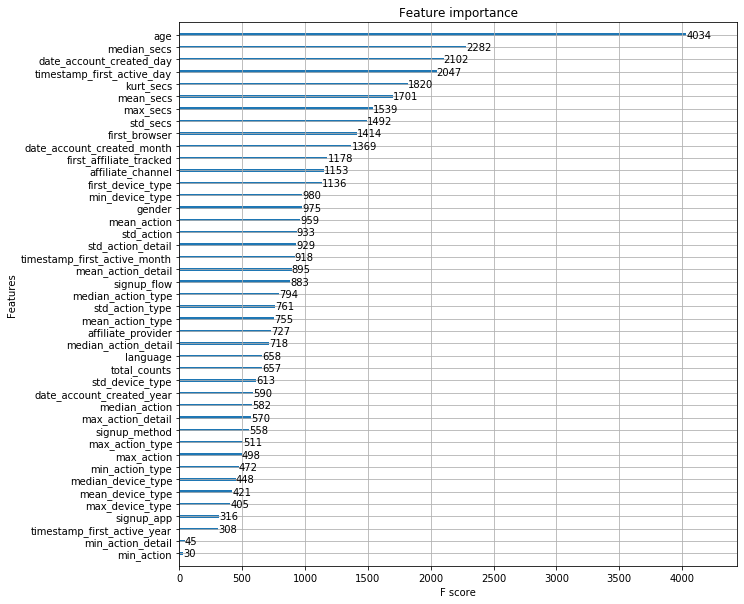

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_importance(xgb, ax=ax)
#perm = PermutationImportance(abc, random_state=1).fit(X_val, y_val)
#eli5.show_weights(perm, feature_names = X_val.columns.tolist())

Lets do some feature selection to reduce the dimensionality of our dataset. We could use something like PCA but I wanted to compare the results of using the top 15 features. Here we can see that the model achieves pretty much the same performance using less than half of the features.This is a good practice to speed up computation and reduce the number of features needed during prediction and deployment. 

F-Score: 0.6447963270947038
NDCG Score: 0.8283977077928325


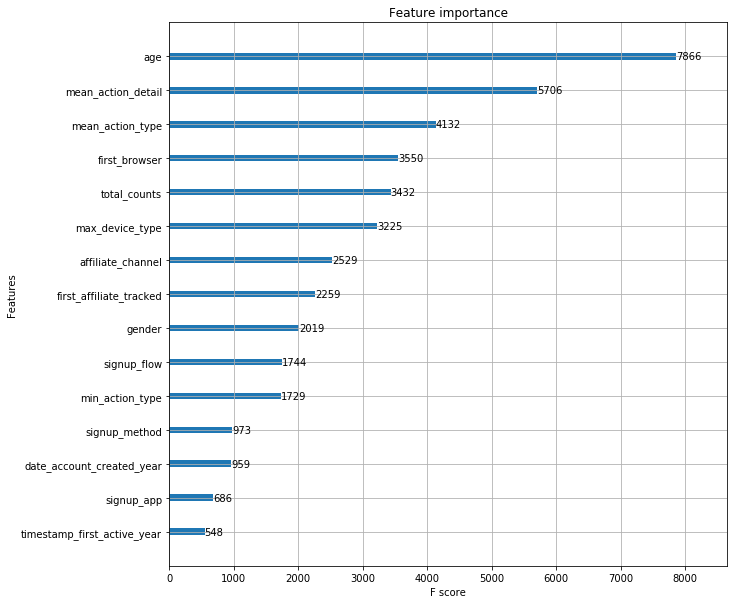

In [27]:
# define custom class to fix bug in xgboost 1.0.2
class MyXGBClassifier(XGBClassifier):
    @property
    def coef_(self):
        return None
    
# do feature selection of top 15 features
selection = SelectFromModel(xgb, threshold=-np.inf, max_features=15, prefit=True)
cols = X_train.columns[selection.get_support()]
x_train = pd.DataFrame(data=selection.transform(X_train), columns=cols)
x_val = pd.DataFrame(data=selection.transform(X_val), columns=cols)

# build a new model using stratified 5-fold CV 
xgb2 = MyXGBClassifier(XGBClassifier(objective='rank:ndcg', eval_metric='ndcg'))
#params = {'learning_rate': [0.05, 0.1, 0.2], 'max_depth': [10, 30, 50], 'n_estimators': [100, 200, 500]}
#skcv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
#xgb2 = GridSearchCV(xgb2, params, n_jobs=5, cv=skcv, scoring='f1_macro', verbose=2, refit=True)
xgb2.fit(x_train, y_train)
print("F-Score: {}".format(xgb2.score(x_val, y_val)))

y_pred = xgb2.predict_proba(x_val)
y_true = LabelBinarizer().fit_transform(y_val)
print("NDCG Score: {}".format(ndcg_score(y_true, y_pred, k=5)))

fig, ax = plt.subplots(figsize=(10, 10))
plot_importance(xgb2, ax=ax)

### Decision Tree Structure

Viewing the tree structure is a good way to explain the logic behind decision tree models. For each split, the model computes the entropy and information gain for each feature/node. Each node represents the feature that the model using and age is at the top because it contributes to the most information gain from the split. 

- **Entropy** - a measure of how much variance/classes the data has. Entropy = 0 indicates the  dataset only has 1 class. Entropy = 1 indicates there are same number of classes in the dataset.
- **Information Gain** - a measure to quantify the quality of a split using a feature. It is computed using Entropy(original) - Entropy(feature_split). The higher the information gain, the better the feature is at helping us predict between classes.

Read more about the mathematics behind entropy and information gain [here](https://victorzhou.com/blog/information-gain/).

In [28]:
from matplotlib.pylab import rcParams

plot_tree(xgb2, num_trees=1) # needs conda install graphviz
fig = plt.gcf()
fig.set_size_inches(300, 300)
fig.savefig('tree.png')
#tree_graph = tree.export_graphviz(abc, feature_names=X_train.columns.values)
#graphviz.Source(tree_graph)

### Partial Dependence Plot

While feature importance shows **what** variables most affect predictions, partial dependence plots show **how** a feature affects predictions as it increases in value. This is useful to help us answer questions like how does age affect the country destination booked?


From the plots below we see that the relationship between age and each of the 12 classes are being plotted. The y axis is interpreted as change in the prediction from what it would be predicted at the baseline or leftmost value. A blue shaded area indicates level of confidence.

For countries 0, 1, 5, 9, 10 - we see that as age increases, the probability of people booking the country increases up to ~40 years old. Hence we can conclude that middle-aged people prefer them.

For countries - 2, 3, 4, 6, 7, 8 - we see that as age increases, the probability of people booking the country decreases. Hence we can conclude that younger people prefer them.

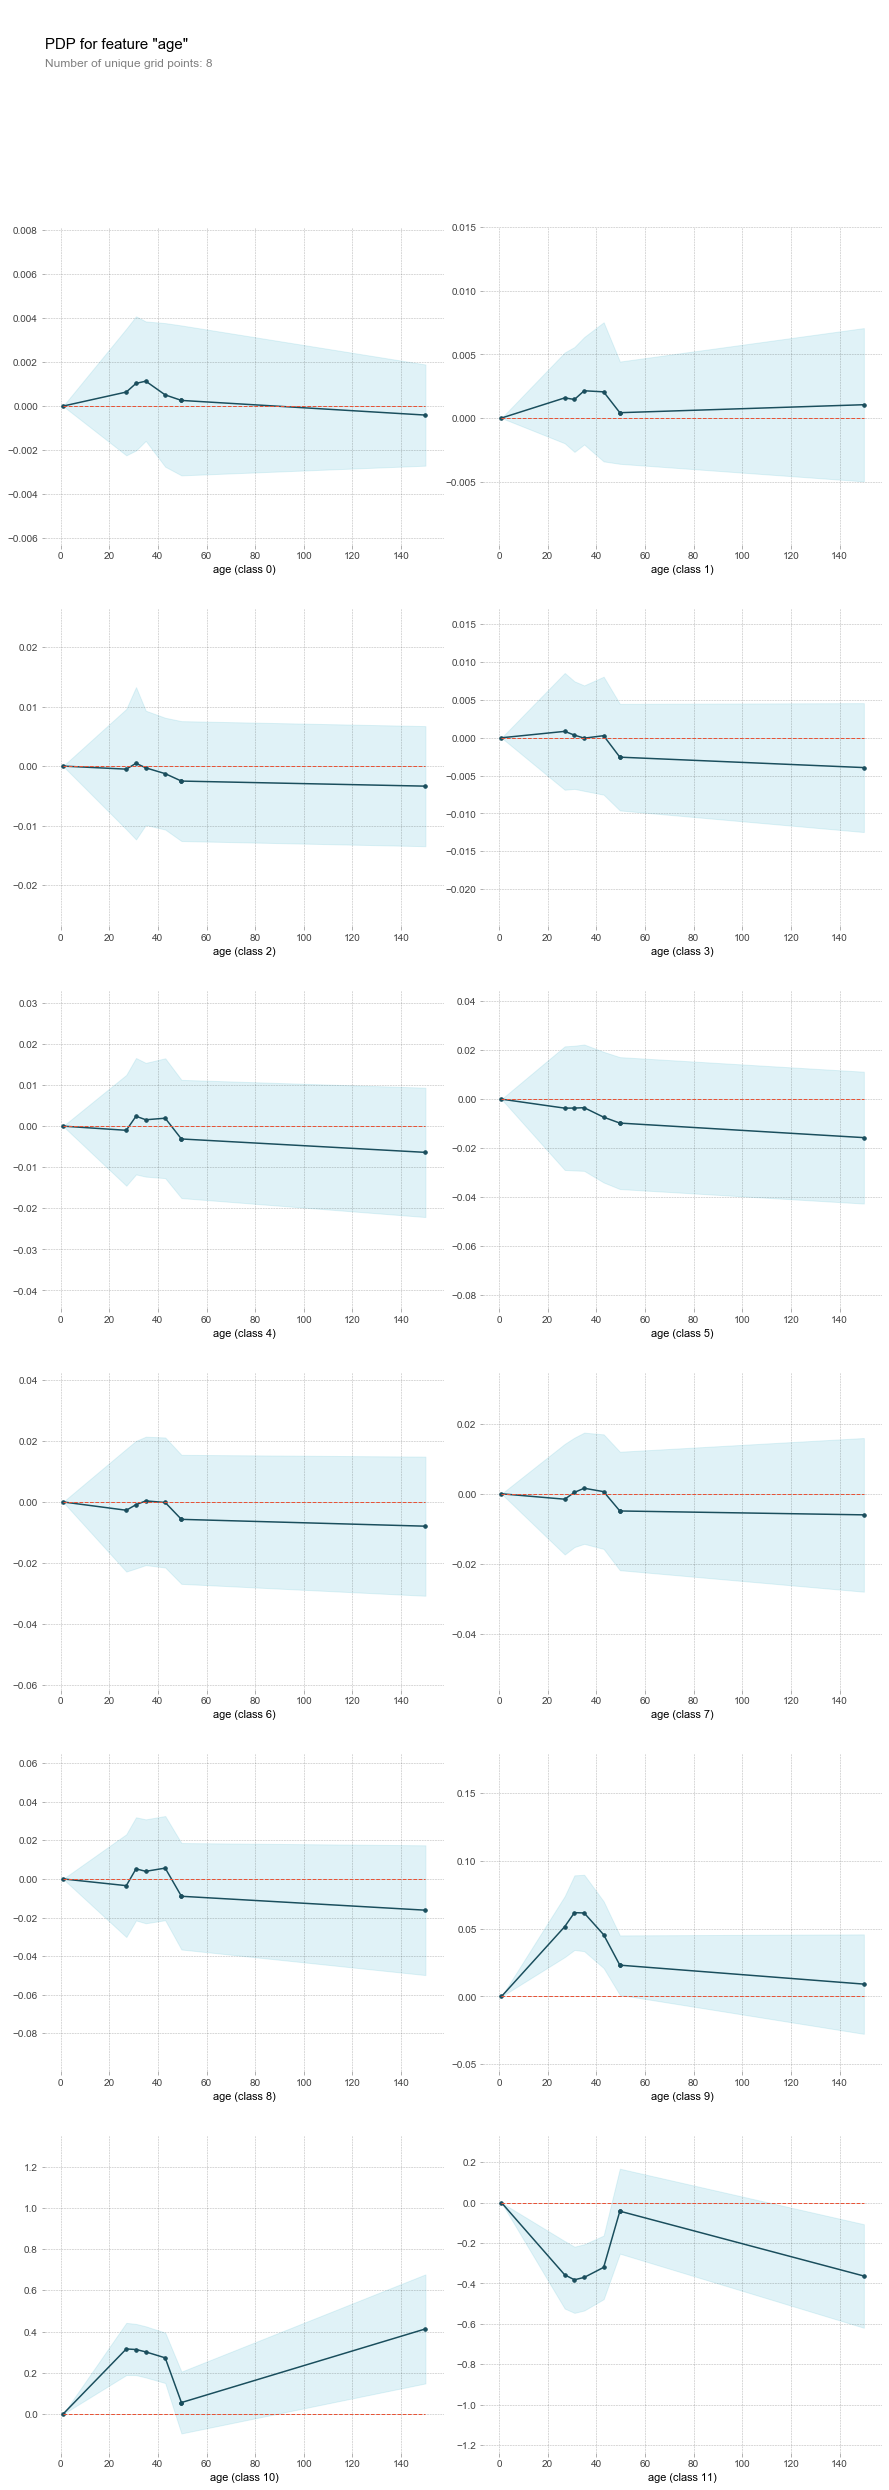

In [30]:
## Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=xgb2, 
                            dataset=x_train, 
                            model_features=x_train.columns.values, 
                            feature='age')

# plot it
pdp.pdp_plot(pdp_goals, 'age')
plt.show()

### SHAP Values

Finally we can also use Shapley Additive Explanations (SHAP Values) to break down a prediction and show the impact of each feature.  It does this by interpreting the impact of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value. Where could you use this?

- A model says a bank shouldn't loan someone money, and the bank is legally required to explain the basis for each loan rejection
- A healthcare provider wants to identify what factors are driving each patient's risk of some disease so they can directly address those risk factors with targeted health interventions


explainer = shap.TreeExplainer(xgb2)
shap_values = explainer.shap_values(x_val)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], x_val)